In [41]:
import numpy as np
from HARK.ConsumptionSaving.ConsPortfolioModel import SequentialPortfolioConsumerType
import matplotlib.pyplot as plt
from sharkfin.population import SharkPopulation, SharkPopulationSolution
from sharkfin.utilities import price_dividend_ratio_random_walk
from simulate.parameters import WHITESHARK, LUCAS0

In [42]:
from sharkfin.expectations import UsualExpectations
from sharkfin.markets import MockMarket

## Setup

In [43]:
LUCAS0

{'cycles': 0,
 'aNrmInitStd': 1.0,
 'aNrmInitMean': 6,
 'LivPrb': [0.9949620563926881],
 'PermGroFac': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'Rfree': 1.0,
 'TranShkStd': [0],
 'PermShkStd': [0],
 'UnempPrb': 0.0,
 'CRRA': 3,
 'DiscFac': 0.99,
 'ex_post': None,
 'AgentCount': 1,
 'num_per_type': 1000}

In [44]:
dividend_growth_rate = 1.000203
dividend_std = 0.011983

rng = 23409

market_args = {
    "dividend_growth_rate": dividend_growth_rate,
    "dividend_std": dividend_std,
    "rng": rng,
    "price_to_dividend_ratio": price_dividend_ratio_random_walk(
        LUCAS0["DiscFac"], LUCAS0["CRRA"], dividend_growth_rate, dividend_std
    ),
}

subjective_return: 0.9999130331113283


In [45]:
ue = UsualExpectations(MockMarket(**market_args))
ue.calculate_risky_expectations()
risky_expectations = ue.risky_expectations()

In [46]:
parameter_dict = LUCAS0.copy()

In [47]:
parameter_dict["aNrmInitMean"] = 1
parameter_dict["aNrmInitStd"] = 0.1

In [48]:
parameter_dict.update(risky_expectations)

In [49]:
parameter_dict

{'cycles': 0,
 'aNrmInitStd': 0.1,
 'aNrmInitMean': 1,
 'LivPrb': [0.9949620563926881],
 'PermGroFac': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'Rfree': 1.0,
 'TranShkStd': [0],
 'PermShkStd': [0],
 'UnempPrb': 0.0,
 'CRRA': 3,
 'DiscFac': 0.99,
 'ex_post': None,
 'AgentCount': 1,
 'num_per_type': 1000,
 'RiskyAvg': 1.0175492133848216,
 'RiskyStd': 0.09283741339989003}

In [50]:
parameter_dict["T_sim"] = 4000

In [51]:
pop = SharkPopulation(
    SequentialPortfolioConsumerType,
    parameter_dict,
    dollars_per_hark_money_unit=1000,
)

In [52]:
if "approx_params" in parameter_dict:
    pop.approx_distributions(parameter_dict["approx_params"])
else:
    pop.continuous_distributions = {}
    pop.discrete_distributions = {}

In [53]:
pop.create_distributed_agents()
pop.create_database()
pop.solve_distributed_agents()

In [54]:
# merge_by=["RiskyAvg", "RiskyStd"])
pop.solve(merge_by=parameter_dict["ex_post"])

In [55]:
pop.explode_agents(30)

In [56]:
for ag in pop.agent_database["agents"]:
    ag.track_vars += ["aNrm", "TranShk"]
    ag.assign_parameters(sim_common_Rrisky=False)

In [57]:
a0h = pop.agent_database["agents"][0]

In [58]:
a0h

<HARK.ConsumptionSaving.ConsPortfolioModel.SequentialPortfolioConsumerType object at 0x2d42c8b45b0.
Parameters:
cycles: 0
CRRA: 3
Rfree: 1.0
DiscFac: 0.99
LivPrb: [0.9949620563926881]
PermGroFac: [1.0]
BoroCnstArt: 0.0
MaxKinks: 400
AgentCount: 1
aNrmInitMean: 1
aNrmInitStd: 0.1
pLvlInitMean: 0.0
pLvlInitStd: 0.0
PermGroFacAgg: 1.0
T_age: None
T_cycle: 1
PerfMITShk: False
aXtraMin: 0.001
aXtraMax: 100
aXtraNestFac: 1
aXtraCount: 200
aXtraExtra: [None]
PermShkStd: [0]
PermShkCount: 7
TranShkStd: [0]
TranShkCount: 7
UnempPrb: 0.0
UnempPrbRet: 0.005
IncUnemp: 0.3
IncUnempRet: 0.0
tax_rate: 0.0
T_retire: 0
vFuncBool: False
CubicBool: False
neutral_measure: False
NewbornTransShk: False
RiskyAvg: 1.0175492133848216
RiskyStd: 0.09283741339989003
RiskyCount: 5
AdjustPrb: 1.0
sim_common_Rrisky: False
ShareCount: 25
DiscreteShareBool: False
num_per_type: 1000
T_sim: 4000>

In [59]:
PARAMS = a0h.parameters

PARAMS["aNrmInitMean"] = 1
PARAMS["aNrmInitStd"] = 0.01
PARAMS["T_sim"] = 2000

at = SequentialPortfolioConsumerType(**PARAMS)
at.assign_parameters(AgentCount=1500)

at.track_vars += ["aNrm", "cNrm", "Risky", "Share", "aLvl"]
at.solve()

## Using the solution functions

In [60]:
cFunc = at.solution[0].cFuncAdj
ShareFunc = at.solution[0].ShareFuncAdj

In [61]:
def expected_increase(mNrm):
    share = ShareFunc(mNrm)

    aNrm = mNrm - cFunc(mNrm)

    mNrm_next = (
        aNrm
        * (share * at.parameters["RiskyAvg"] + (1 - share) * at.parameters["Rfree"])
        + 1
    )

    gain = mNrm_next - aNrm

    return gain

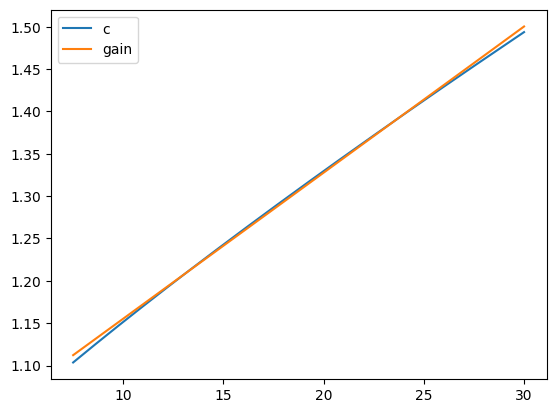

In [62]:
mNrm = np.linspace(7.5, 30, 1000)

plt.plot(mNrm, cFunc(mNrm), label="c")

plt.plot(mNrm, expected_increase(mNrm), label="gain")

plt.legend()

In [63]:
def expected_cash_on_hand(mNrm):
    share = ShareFunc(mNrm)

    aNrm = mNrm - cFunc(mNrm)

    mNrm_next = (
        aNrm
        * (share * at.parameters["RiskyAvg"] + (1 - share) * at.parameters["Rfree"])
        + 1
    )

    

    return mNrm_next

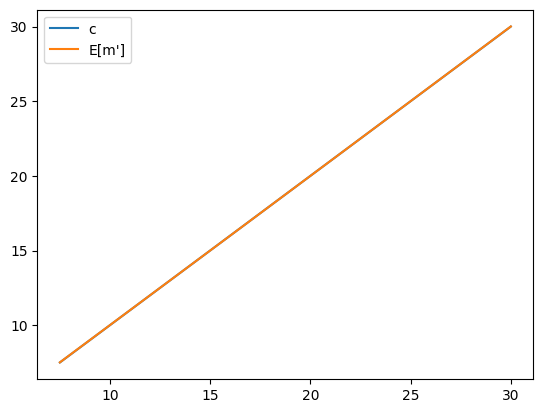

In [64]:
mNrm = np.linspace(7.5, 30, 1000)

plt.plot(mNrm, mNrm, label="c")

plt.plot(mNrm, expected_cash_on_hand(mNrm), label="E[m']")

plt.legend()

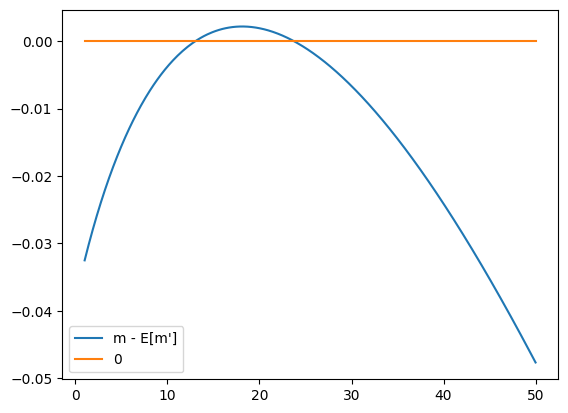

In [76]:
mNrm = np.linspace(1, 50, 1000)


plt.plot(mNrm, mNrm - expected_cash_on_hand(mNrm), label="m - E[m']")
plt.plot(mNrm, np.zeros_like(mNrm), label="0")

plt.legend()

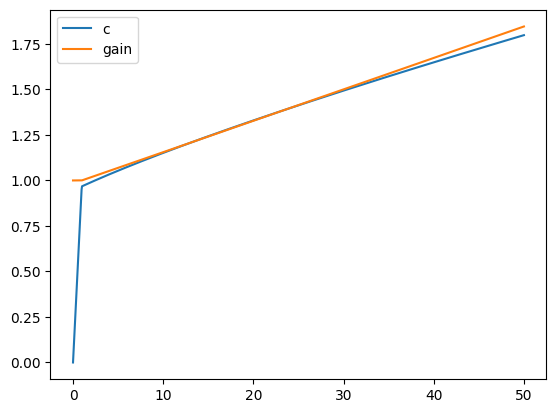

In [66]:
mNrm = np.linspace(0, 50, 1000)

plt.plot(mNrm, cFunc(mNrm), label="c")

plt.plot(mNrm, expected_increase(mNrm), label="gain")

plt.legend()

In [67]:
expected_increase(mNrm) > cFunc(mNrm)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

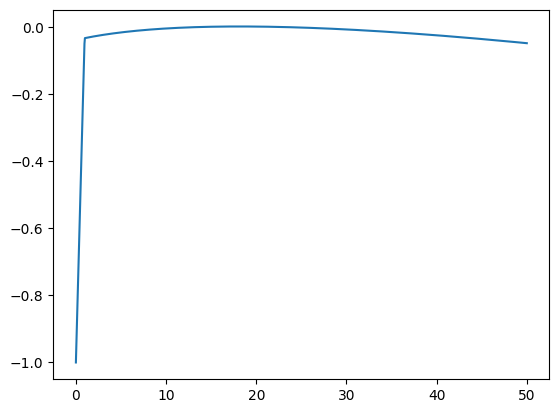

In [68]:
plt.plot(mNrm, cFunc(mNrm) - expected_increase(mNrm), label="c - gain ")

## Simulating with SharkPopulation

In [69]:
a0h.parameters

{'cycles': 0,
 'CRRA': 3,
 'Rfree': 1.0,
 'DiscFac': 0.99,
 'LivPrb': [0.9949620563926881],
 'PermGroFac': [1.0],
 'BoroCnstArt': 0.0,
 'MaxKinks': 400,
 'AgentCount': 1,
 'aNrmInitMean': 1,
 'aNrmInitStd': 0.01,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'PermGroFacAgg': 1.0,
 'T_age': None,
 'T_cycle': 1,
 'PerfMITShk': False,
 'aXtraMin': 0.001,
 'aXtraMax': 100,
 'aXtraNestFac': 1,
 'aXtraCount': 200,
 'aXtraExtra': [None],
 'PermShkStd': [0],
 'PermShkCount': 7,
 'TranShkStd': [0],
 'TranShkCount': 7,
 'UnempPrb': 0.0,
 'UnempPrbRet': 0.005,
 'IncUnemp': 0.3,
 'IncUnempRet': 0.0,
 'tax_rate': 0.0,
 'T_retire': 0,
 'vFuncBool': False,
 'CubicBool': False,
 'neutral_measure': False,
 'NewbornTransShk': False,
 'RiskyAvg': 1.0175492133848216,
 'RiskyStd': 0.09283741339989003,
 'RiskyCount': 5,
 'AdjustPrb': 1.0,
 'sim_common_Rrisky': False,
 'ShareCount': 25,
 'DiscreteShareBool': False,
 'num_per_type': 1000,
 'T_sim': 2000}

In [70]:
# initialize population model
pop.init_simulation()

In [71]:
pop.simulate()

KeyboardInterrupt: 

In [ ]:
assert (
    pop.agent_database["agents"].map(lambda a: a.history["mNrm"][100]).std()
    > 0.00000001
)

In [ ]:
import pandas as pd

hist = pop.agent_database["agents"][0].history

data = pd.concat(
    [
        pd.DataFrame(
            {var: np.log(agent.history[var].flatten()) for var in agent.history}
        ).reset_index()
        for agent in pop.agent_database["agents"]
    ]
)

In [ ]:
data.shape

(30000, 8)

<Axes: xlabel='index', ylabel='mNrm'>

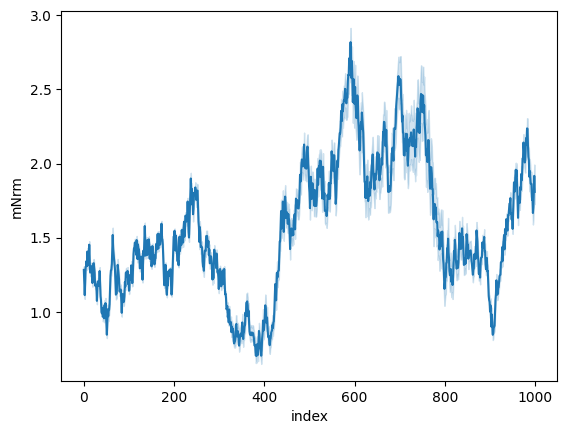

In [ ]:
import seaborn as sns

sns.lineplot(data=data, x="index", y="mNrm")

<Axes: xlabel='index', ylabel='cNrm'>

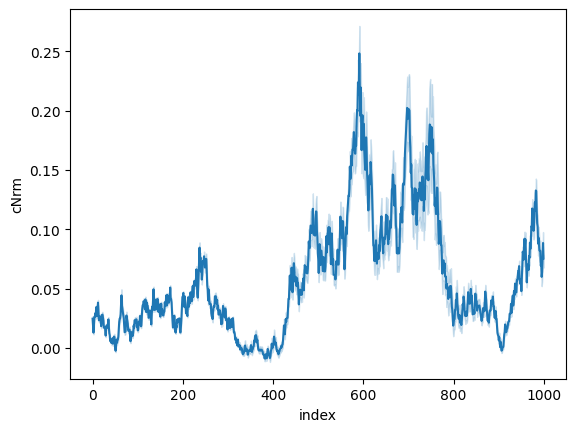

In [ ]:
sns.lineplot(data=data, x="index", y="cNrm")

In [ ]:
data.columns

Index(['index', 'aNrm', 'TranShk', 'pLvl', 'mNrm', 'cNrm', 'Share', 'Risky'], dtype='object')

<Axes: xlabel='index', ylabel='Risky'>

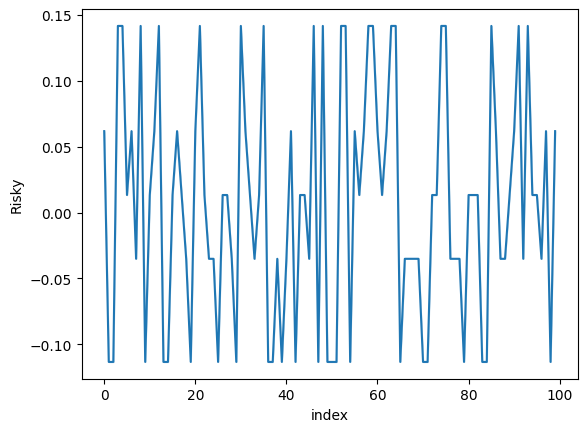

In [ ]:
sns.lineplot(data=data[data["index"] < 100], x="index", y="Risky")

## Single AgentType testing (should be faster)

In [ ]:
PARAMS = a0h.parameters

PARAMS["aNrmInitMean"] = 1
PARAMS["aNrmInitStd"] = 0.01
PARAMS["T_sim"] = 2000

In [ ]:
at = SequentialPortfolioConsumerType(**PARAMS)
at.assign_parameters(AgentCount=1500)

at.track_vars += ["aNrm", "cNrm", "Risky", "Share", "aLvl"]
at.solve()
at.initialize_sim()
at.simulate()

KeyboardInterrupt: 

In [ ]:
agent_histories = []

for a in range(3):
    df = pd.DataFrame(
        {"log_" + var: np.log(at.history[var][:, a].flatten()) for var in at.history}
    ).reset_index()
    df = df.rename(columns={"index": "t"})
    df["agent"] = a
    agent_histories.append(df)

data = pd.concat(agent_histories)

<Axes: xlabel='t', ylabel='log_aLvl'>

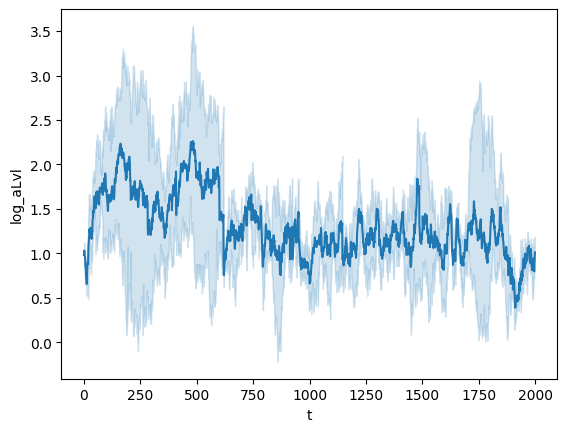

In [ ]:
sns.lineplot(data=data, x="t", y="log_aLvl")

<Axes: xlabel='t', ylabel='log_aNrm'>

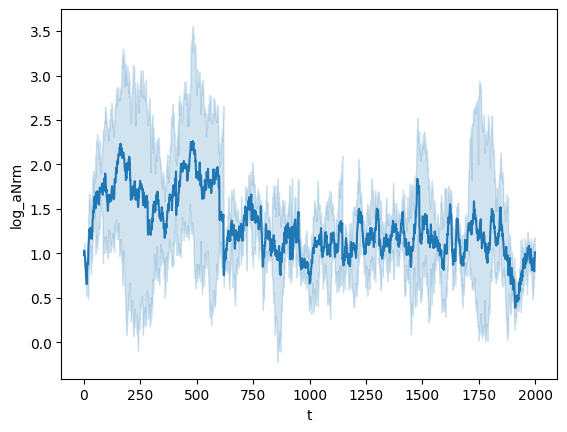

In [ ]:
sns.lineplot(data=data, x="t", y="log_aNrm")

In [ ]:
np.log(4000)

8.294049640102028

In [ ]:
data[data["t"] > 3000]["log_aNrm"].mean()

nan

In [ ]:
np.exp(data[data["t"] > 3000]["log_aNrm"].mean())

nan

<Axes: xlabel='t', ylabel='log_Risky'>

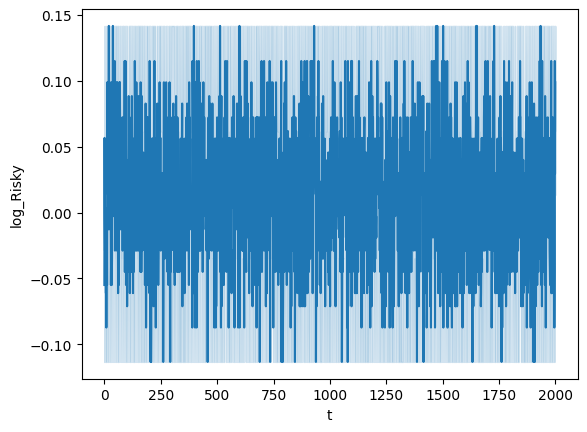

In [ ]:
sns.lineplot(data=data, x="t", y="log_Risky")

<Axes: xlabel='t', ylabel='log_cNrm'>

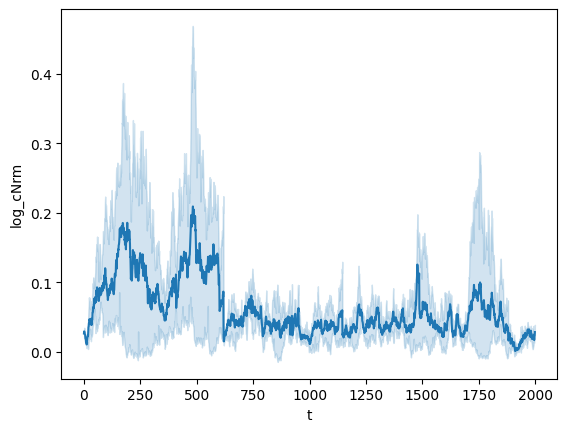

In [ ]:
sns.lineplot(data=data, x="t", y="log_cNrm")

<Axes: xlabel='t', ylabel='log_Share'>

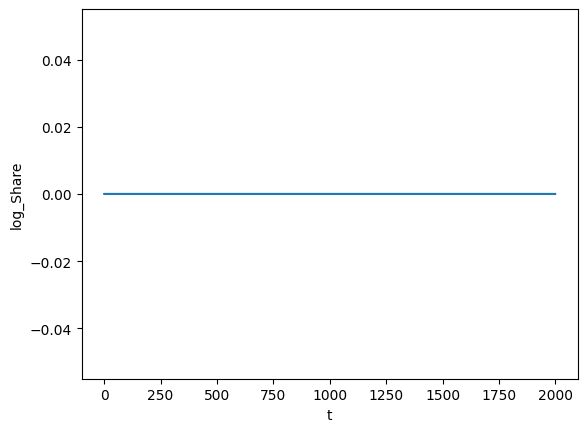

In [ ]:
sns.lineplot(data=data, x="t", y="log_Share")